<a href="https://colab.research.google.com/github/ritwiks9635/My_Neural_Network_Architecture/blob/main/Multiple_Instance_Learning_(MIL)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#****Classification using Attention-based Deep Multiple Instance Learning (MIL)****

# **What is Multiple Instance Learning (MIL)?**
Usually, with supervised learning algorithms, the learner receives labels for a set of instances. In the case of MIL, the learner receives labels for a set of bags, each of which contains a set of instances. The bag is labeled positive if it contains at least one positive instance, and negative if it does not contain any.


(**Motivation**)


It is often assumed in image classification tasks that each image clearly represents a class label. In medical imaging (e.g. computational pathology, etc.) an entire image is represented by a single class label (cancerous/non-cancerous) or a region of interest could be given. However, one will be interested in knowing which patterns in the image is actually causing it to belong to that class. In this context, the image(s) will be divided and the subimages will form the bag of instances.

Therefore, the goals are to:

Learn a model to predict a class label for a bag of instances.Find out which instances within the bag caused a position class label prediction.
**Implementation**



The following steps describe how the model works:
The feature extractor layers extract feature embeddings.The embeddings are fed into the MIL attention layer to get the attention scores. The layer is designed as permutation-invariant.Input features and their corresponding attention scores are multiplied together.The resulting output is passed to a softmax function for classification.

In [ ]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers

plt.style.use("ggplot")

***Create dataset:::***
We will create a set of bags and assign their labels according to their contents. If at least one positive instance is available in a bag, the bag is considered as a positive bag. If it does not contain any positive instance, the bag will be considered as negative.
***Configuration parameters:::***POSITIVE_CLASS: The desired class to be kept in the positive bag.BAG_COUNT: The number of training bags.VAL_BAG_COUNT: The number of validation bags.BAG_SIZE: The number of instances in a bag.PLOT_SIZE: The number of bags to plot.ENSEMBLE_AVG_COUNT: The number of models to create and average together. (Optional: often results in better performance - set to 1 for single model

In [ ]:
Positive_class = 1
Bag_count = 1000
Val_bag_count = 300
Bag_size = 3
Plot_size = 3
Ensemble_avg_count = 1

In [ ]:
def create_bags(input_data, input_label, positive_class, bag_count, instance_count):
    bags = []
    bag_labels = []
    input_data = np.divide(input_data, 255.0)
    count = 0

    for _  in range(bag_count):
        index = np.random.choice(input_data.shape[0], instance_count, replace = False)
        instance_data = input_data[index]
        instance_label = input_label[index]

        bag_label = 0

        if positive_class in instance_label:
            bag_label = 1
            count += 1
        bags.append(instance_data)
        bag_labels.append(np.array([bag_label]))

    print(f"Positive bags: {count}")
    print(f"Negative bags: {bag_count - count}")
    return (list(np.swapaxes(bags, 0, 1)), np.array(bag_labels))

In [ ]:
(x_train, y_train),(x_val, y_val) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
train_data, train_label = create_bags(x_train, y_train, Positive_class, Bag_count, Bag_size)

Positive bags: 299
Negative bags: 701


In [ ]:
val_data, val_label = create_bags(x_val, y_val, Positive_class, Val_bag_count, Bag_size)

Positive bags: 95
Negative bags: 205


***Create the model***

We will now build the attention layer, prepare some utilities, then build and train the entire model.

***Attention operator implementation***

The output size of this layer is decided by the size of a single bag.
The attention mechanism uses a weighted average of instances in a bag, in which the sum of the weights must equal to 1 (invariant of the bag size).
The weight matrices (parameters) are w and v. To include positive and negative values, hyperbolic tangent element-wise non-linearity is utilized.
A Gated attention mechanism can be used to deal with complex relations. Another weight matrix, u, is added to the computation. A sigmoid non-linearity is used to overcome approximately linear behavior for x ∈ [−1, 1] by hyperbolic tangent non-linearity.

In [ ]:
class MILAttentionLayer(layers.Layer):
    """Implementation of the attention-based Deep MIL layer.

    Args:
      weight_params_dim: Positive Integer. Dimension of the weight matrix.
      kernel_initializer: Initializer for the `kernel` matrix.
      kernel_regularizer: Regularizer function applied to the `kernel` matrix.
      use_gated: Boolean, whether or not to use the gated mechanism.

    Returns:
      List of 2D tensors with BAG_SIZE length.
      The tensors are the attention scores after softmax with shape `(batch_size, 1)`.
    """

    def __init__(
        self,
        weight_params_dim,
        kernel_initializer="glorot_uniform",
        kernel_regularizer=None,
        use_gated=False,
        **kwargs,
    ):

        super().__init__(**kwargs)

        self.weight_params_dim = weight_params_dim
        self.use_gated = use_gated

        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)

        self.v_init = self.kernel_initializer
        self.w_init = self.kernel_initializer
        self.u_init = self.kernel_initializer

        self.v_regularizer = self.kernel_regularizer
        self.w_regularizer = self.kernel_regularizer
        self.u_regularizer = self.kernel_regularizer

    def build(self, input_shape):

        # Input shape.
        # List of 2D tensors with shape: (batch_size, input_dim).
        input_dim = input_shape[0][1]

        self.v_weight_params = self.add_weight(
            shape=(input_dim, self.weight_params_dim),
            initializer=self.v_init,
            name="v",
            regularizer=self.v_regularizer,
            trainable=True,
        )

        self.w_weight_params = self.add_weight(
            shape=(self.weight_params_dim, 1),
            initializer=self.w_init,
            name="w",
            regularizer=self.w_regularizer,
            trainable=True,
        )

        if self.use_gated:
            self.u_weight_params = self.add_weight(
                shape=(input_dim, self.weight_params_dim),
                initializer=self.u_init,
                name="u",
                regularizer=self.u_regularizer,
                trainable=True,
            )
        else:
            self.u_weight_params = None

        self.input_built = True

    def call(self, inputs):

        # Assigning variables from the number of inputs.
        instances = [self.compute_attention_scores(instance) for instance in inputs]

        # Apply softmax over instances such that the output summation is equal to 1.
        alpha = tf.math.softmax(instances, axis=0)

        return [alpha[i] for i in range(alpha.shape[0])]

    def compute_attention_scores(self, instance):

        # Reserve in-case "gated mechanism" used.
        original_instance = instance

        # tanh(v*h_k^T)
        instance = tf.math.tanh(tf.tensordot(instance, self.v_weight_params, axes=1))

        # for learning non-linear relations efficiently.
        if self.use_gated:

            instance = instance * tf.math.sigmoid(
                tf.tensordot(original_instance, self.u_weight_params, axes=1)
            )

        # w^T*(tanh(v*h_k^T)) / w^T*(tanh(v*h_k^T)*sigmoid(u*h_k^T))
        return tf.tensordot(instance, self.w_weight_params, axes=1)

In [ ]:
def plot(data, labels, bag_class, prediction = None, attention_weights = None):
    labels = np.array(labels).reshape(-1)

    if bag_class == "positive":

        if prediction is not None:
            labels = np.where(prediction.argmax(1) == 1)[0]
            bags = np.array(data)[:, labels[0:Plot_size]]

        else:
            labels = np.where(labels == 1)[0]
            bags = np.array(data)[:, labels[0:Plot_size]]

    elif bag_class == "negative":

        if prediction is not None:
            labels = np.where(prediction.argmax(1) == 0)[0]
            bags = np.array(data)[:, labels[0:Plot_size]]

        else:
            labels = np.where(labels == 0)[0]
            bags = np.array(data)[:, labels[0:Plot_size]]

    else:
        print(f"There is no class {bag_class}")
        return

    print(f"The bag class label is {bag_class}")
    for i in range(Plot_size):
        figure = plt.figure(figsize=(8, 8))
        print(f"Bag number: {labels[i]}")
        for j in range(Bag_size):
            image = bags[j][i]
            figure.add_subplot(1, Bag_size, j + 1)
            plt.grid(False)
            if attention_weights is not None:
                plt.title(np.around(attention_weights[labels[i]][j], 2))
            plt.imshow(image)
        plt.show()

The bag class label is positive
Bag number: 0


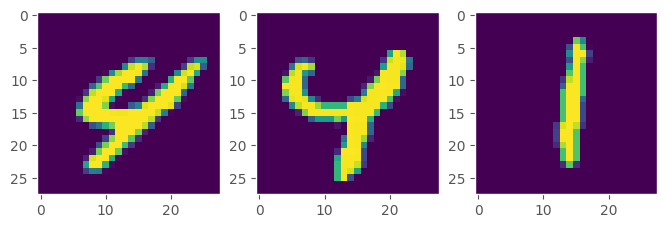

Bag number: 7


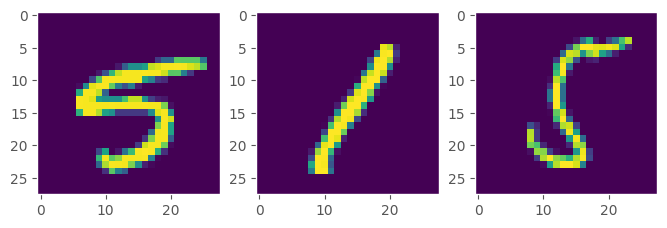

Bag number: 13


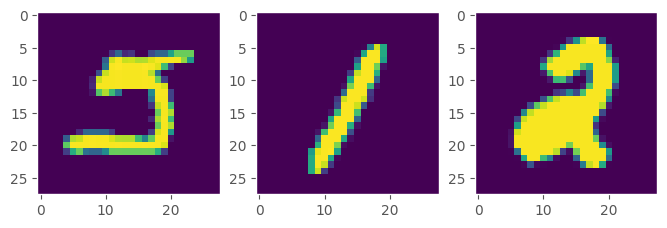

The bag class label is negative
Bag number: 1


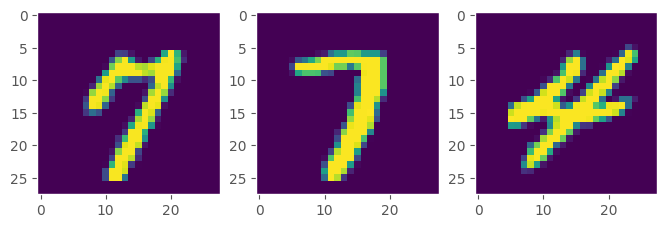

Bag number: 2


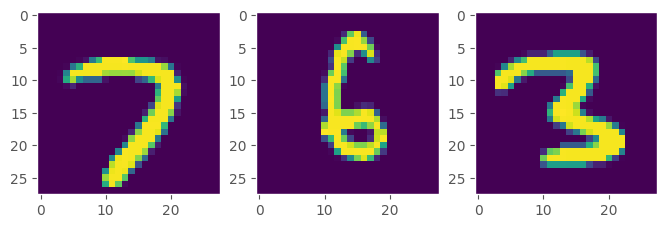

Bag number: 3


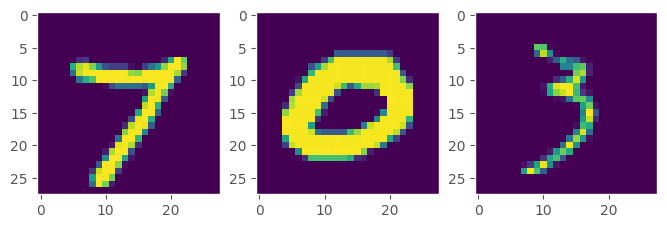

In [ ]:
plot(val_data, val_label, "positive")
plot(val_data, val_label, "negative")

In [ ]:
def create_model(instance_shape):
    inputs, embeddings = [], []
    dense_layer_1 = layers.Dense(128, activation = "relu")
    dense_layer_2 = layers.Dense(64, activation = "relu")
    for _ in range(Bag_size):
        input = layers.Input(instance_shape)
        flatten = layers.Flatten()(input)
        dense1 = dense_layer_1(flatten)
        dense2 = dense_layer_2(dense1)
        inputs.append(input)
        embeddings.append(dense2)

    alpha = MILAttentionLayer(
        weight_params_dim=256,
        kernel_regularizer=keras.regularizers.l2(0.01),
        use_gated=True,
        name="alpha",
        )(embeddings)

    multiply_layers = [
        layers.multiply([alpha[i], embeddings[i]]) for i in range(len(alpha))]

    concat = layers.concatenate(multiply_layers, axis = 1)

    output = layers.Dense(2, activation = "softmax")(concat)
    return keras.Model(inputs, output)

***::Class weights::***

Since this kind of problem could simply turn into imbalanced data classification problem, class weighting should be considered.
Let's say there are 1000 bags. There often could be cases were ~90 % of the bags do not contain any positive label and ~10 % do. Such data can be referred to as Imbalanced data.
Using class weights, the model will tend to give a higher weight to the rare class.

In [ ]:
def compute_class_weights(labels):

    # Count number of postive and negative bags.
    negative_count = len(np.where(labels == 0)[0])
    positive_count = len(np.where(labels == 1)[0])
    total_count = negative_count + positive_count

    # Build class weight dictionary.
    return {
        0: (1 / negative_count) * (total_count / 2),
        1: (1 / positive_count) * (total_count / 2),
    }

In [ ]:
def train(train_data, train_labels, val_data, val_labels, model):
    file_path = "best_model_weights.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        file_path,
        monitor = "val_loss",
        verbose = 0,
        mode = "min",
        save_best_only = True,
        save_weights_only = True)

    er_stoping = keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        patience = 10,
        mode = "min")

    model.compile(optimizer = "adam", loss="sparse_categorical_crossentropy", metrics = ["accuracy"])

    model.fit(
        train_data,
        train_labels,
        validation_data=(val_data, val_labels),
        epochs=20,
        class_weight=compute_class_weights(train_labels),
        batch_size=1,
        callbacks=[er_stoping, checkpoint],
        verbose=0)

    model.load_weights(file_path)
    return model

In [ ]:
instance_shape = train_data[0][0].shape
model = [create_model(instance_shape) for _ in range(Ensemble_avg_count)]

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
model[0].summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28)]             0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 28, 28)]             0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 28, 28)]             0         []                            
                                                                                                  
 flatten (Flatten)           (None, 784)                  0         ['input_1[0][0]']             
                                                                                              

In [ ]:
trained_models = [
    train(train_data, train_label, val_data, val_label, model)
    for model in tqdm(model)
]

100%|██████████| 1/1 [01:39<00:00, 99.18s/it]


10/10 [==============================] - 0s 4ms/step
The average loss and accuracy are 0.01 and 99.67 % resp.
The bag class label is positive
Bag number: 0


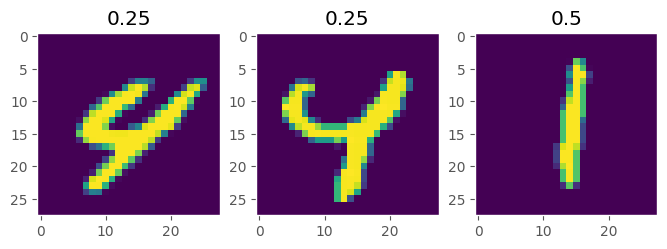

Bag number: 7


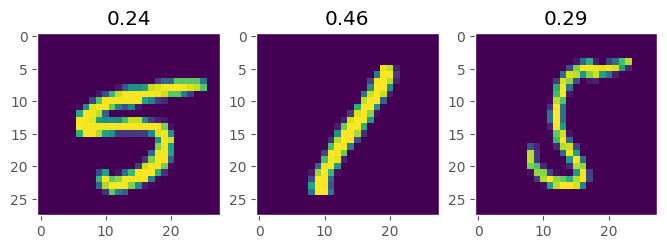

Bag number: 13


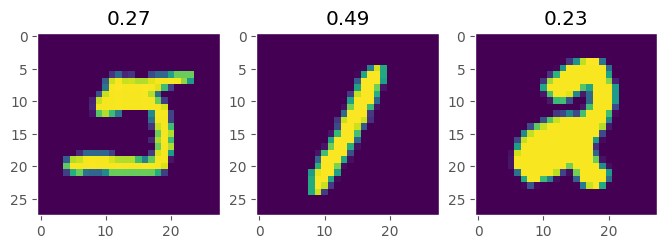

The bag class label is negative
Bag number: 1


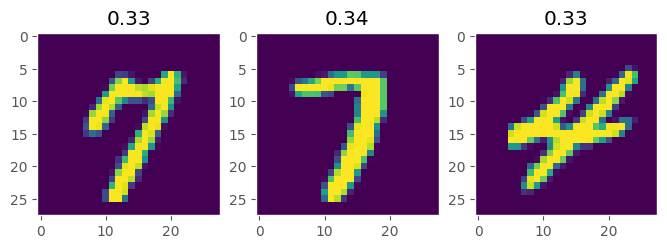

Bag number: 2


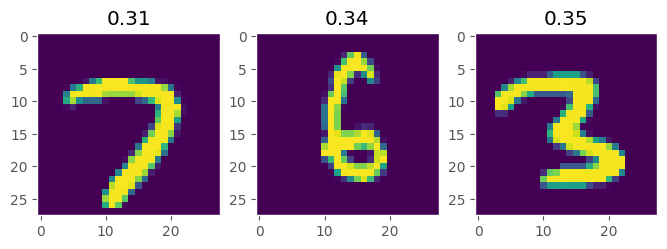

Bag number: 3


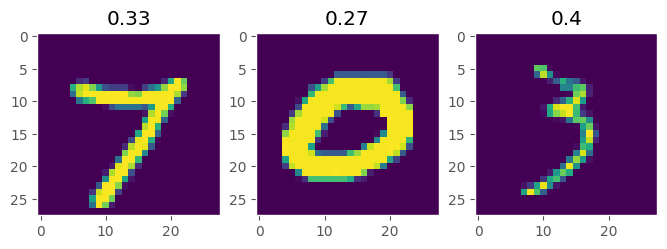

In [ ]:
def predict(data, labels, trained_models):

    # Collect info per model.
    models_predictions = []
    models_attention_weights = []
    models_losses = []
    models_accuracies = []

    for model in trained_models:

        # Predict output classes on data.
        predictions = model.predict(data)
        models_predictions.append(predictions)

        # Create intermediate model to get MIL attention layer weights.
        intermediate_model = keras.Model(model.input, model.get_layer("alpha").output)

        # Predict MIL attention layer weights.
        intermediate_predictions = intermediate_model.predict(data)

        attention_weights = np.squeeze(np.swapaxes(intermediate_predictions, 1, 0))
        models_attention_weights.append(attention_weights)

        loss, accuracy = model.evaluate(data, labels, verbose=0)
        models_losses.append(loss)
        models_accuracies.append(accuracy)

    print(
        f"The average loss and accuracy are {np.sum(models_losses, axis=0) / Ensemble_avg_count:.2f}"
        f" and {100 * np.sum(models_accuracies, axis=0) / Ensemble_avg_count:.2f} % resp."
    )

    return (
        np.sum(models_predictions, axis=0) / Ensemble_avg_count,
        np.sum(models_attention_weights, axis=0) / Ensemble_avg_count,
    )


# Evaluate and predict classes and attention scores on validation data.
class_predictions, attention_params = predict(val_data, val_label, trained_models)

# Plot some results from our validation data.
plot(
    val_data,
    val_label,
    "positive",
    prediction=class_predictions,
    attention_weights=attention_params,
)
plot(
    val_data,
    val_label,
    "negative",
    prediction=class_predictions,
    attention_weights=attention_params,
)

***Conclusion:::***

From the above plot, you can notice that the weights always sum to 1. In a positively predict bag, the instance which resulted in the positive labeling will have a substantially higher attention score than the rest of the bag. However, in a negatively predicted bag, there are two cases:
All instances will have approximately similar scores.An instance will have relatively higher score (but not as high as of a positive instance). This is because the feature space of this instance is close to that of the positive instance.